In [ ]:
%load_ext autoreload
%autoreload 2
from compara_todos import compara_todos

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Testes

In [38]:
Nr = 50      # Número de rodadas
Ptrain = 80  # Percentual de treino

--- CARREGANDO DADOS DE 'recfaces400.dat' ---

--- INICIANDO AVALIAÇÃO DOS CLASSIFICADORES (50 repetições, 80% treino) ---
Avaliando: QDA (Quadrático)...
Classificador: QDA (Quadrático)
Executando QDA...
Rank da matriz de covariância para a classe 1: 5
Rank da matriz de covariância para a classe 2: 9
Rank da matriz de covariância para a classe 3: 9
Rank da matriz de covariância para a classe 4: 8
Rank da matriz de covariância para a classe 5: 8
Rank da matriz de covariância para a classe 6: 8
Rank da matriz de covariância para a classe 7: 6
Rank da matriz de covariância para a classe 8: 6
Rank da matriz de covariância para a classe 9: 6
Rank da matriz de covariância para a classe 10: 9
Rank da matriz de covariância para a classe 11: 9
Rank da matriz de covariância para a classe 12: 8
Rank da matriz de covariância para a classe 13: 9
Rank da matriz de covariância para a classe 14: 4
Rank da matriz de covariância para a classe 15: 7
Finalizado: QDA. Acurácia Média: 6.97%
Avaliando: Varia

,Média (%),Mínimo (%),Máximo (%),Mediana (%),Desvio Padrão,Tempo (s)
QDA (Quadrático),6.97,0.00,15.15,6.06,3.99,27.21
Variante 1 (Tikhonov λ=0.01),79.52,69.70,90.91,78.79,6.11,5.42
Variante 2 (Covariance Pooled),4.73,0.00,21.21,3.03,5.46,29.97
Variante 3 (Friedman λ=0.5),6.91,3.03,12.12,6.06,2.85,39.30
Variante 4 (Naive Bayes),6.73,0.00,18.18,6.06,3.99,36.14
MaxCorr,80.48,69.70,93.94,81.82,5.69,0.03
DMC,76.67,63.64,87.88,77.27,6.07,0.05
1-NN,78.48,60.61,90.91,78.79,6.97,0.13


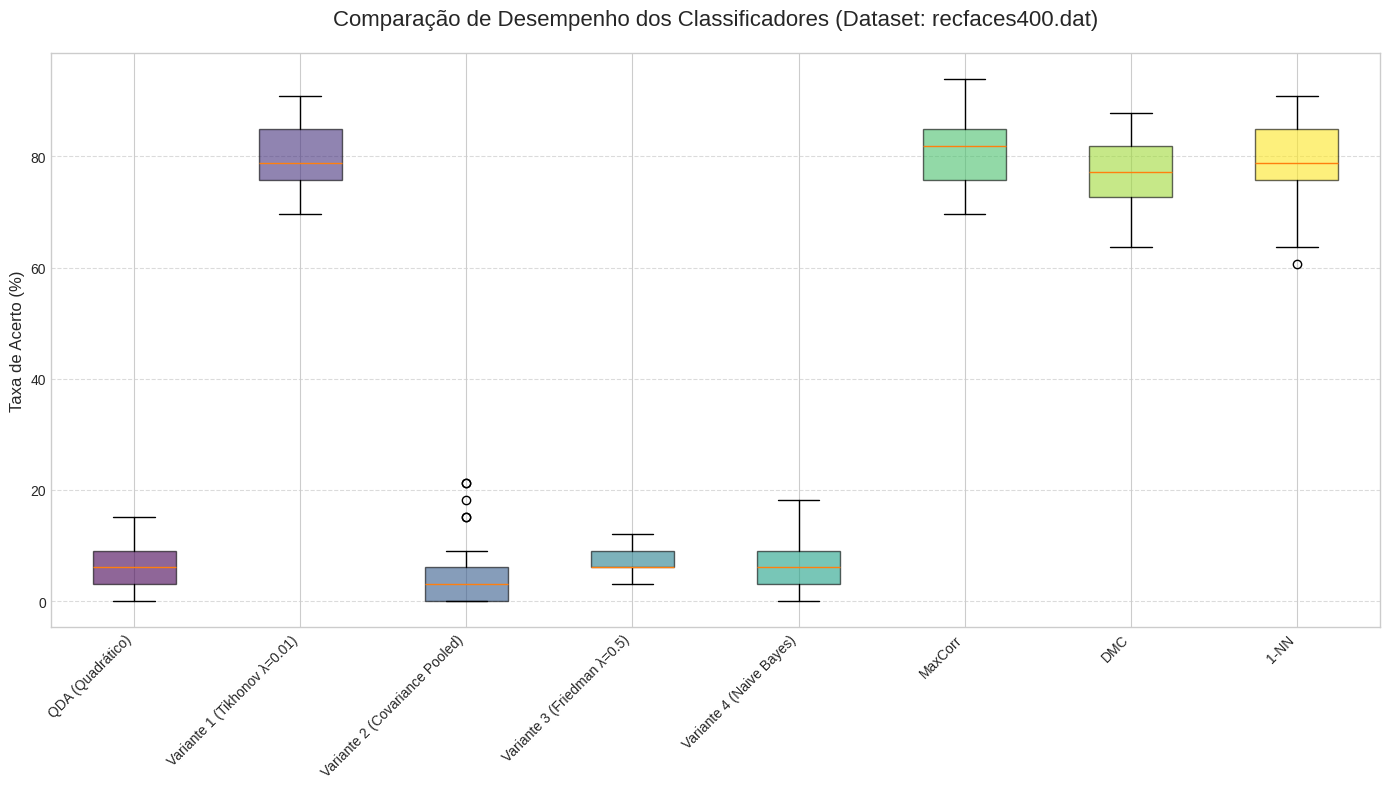

In [39]:
results = compara_todos('recfaces400.dat', Nr, Ptrain)

In [41]:
model_names = [
    "QDA (Quadrático)",
    "Variante 1 (Tikhonov λ=0.01)",
    "Variante 2 (Covariance Pooled)",
    "Variante 3 (Friedman λ=0.5)",
    "Variante 4 (Naive Bayes)"
]

for model in model_names:
    print(f"Postos das matrizes de covariância para {model}:")
    for i in results[1][model]["model_params"]["covariances_rank"]:
        print(results[1][model]["model_params"]["covariances_rank"][i])

Postos das matrizes de covariância para QDA (Quadrático):
5
9
9
8
8
8
6
6
6
9
9
8
9
4
7
Postos das matrizes de covariância para Variante 1 (Tikhonov λ=0.01):
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
Postos das matrizes de covariância para Variante 2 (Covariance Pooled):
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
Postos das matrizes de covariância para Variante 3 (Friedman λ=0.5):
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
Postos das matrizes de covariância para Variante 4 (Naive Bayes):
400
382
389
398
398
372
293
373
281
325
225
329
342
356
398


--- CARREGANDO DADOS DE 'recfaces400[0,1].dat' ---

--- INICIANDO AVALIAÇÃO DOS CLASSIFICADORES (50 repetições, 80% treino) ---
Avaliando: QDA (Quadrático)...
Classificador: QDA (Quadrático)
Executando QDA...
Finalizado: QDA. Acurácia Média: 6.48%
Avaliando: Variante 1 (Tikhonov λ=0.01)...
Classificador: Variante 1 (Tikhonov λ=0.01)
Executando QDA...
Finalizado: QDA. Acurácia Média: 79.76%
Avaliando: Variante 2 (Covariance Pooled)...
Classificador: Variante 2 (Covariance Pooled)
Executando QDA...
Finalizado: QDA. Acurácia Média: 3.39%
Avaliando: Variante 3 (Friedman λ=0.5)...
Classificador: Variante 3 (Friedman λ=0.5)
Executando QDA...
Finalizado: QDA. Acurácia Média: 6.91%
Avaliando: Variante 4 (Naive Bayes)...
Classificador: Variante 4 (Naive Bayes)
Executando QDA...
Finalizado: QDA. Acurácia Média: 8.79%
Avaliando: MaxCorr...
Classificador: MaxCorr
Executando MaxCorr...
Finalizado: MaxCorr. Acurácia Média: 78.73%
Avaliando: DMC...
Classificador: DMC
Executando DMC...
Finalizado: DMC

,Média (%),Mínimo (%),Máximo (%),Mediana (%),Desvio Padrão,Tempo (s)
QDA (Quadrático),6.48,0.00,21.21,6.06,4.29,26.57
Variante 1 (Tikhonov λ=0.01),79.76,69.70,90.91,78.79,5.89,3.92
Variante 2 (Covariance Pooled),3.39,0.00,15.15,3.03,3.67,35.22
Variante 3 (Friedman λ=0.5),6.91,0.00,18.18,6.06,4.70,34.33
Variante 4 (Naive Bayes),8.79,0.00,18.18,9.09,4.34,31.92
MaxCorr,78.73,66.67,93.94,78.79,6.73,0.04
DMC,74.79,60.61,93.94,74.24,7.11,0.06
1-NN,76.55,63.64,90.91,75.76,6.72,0.13


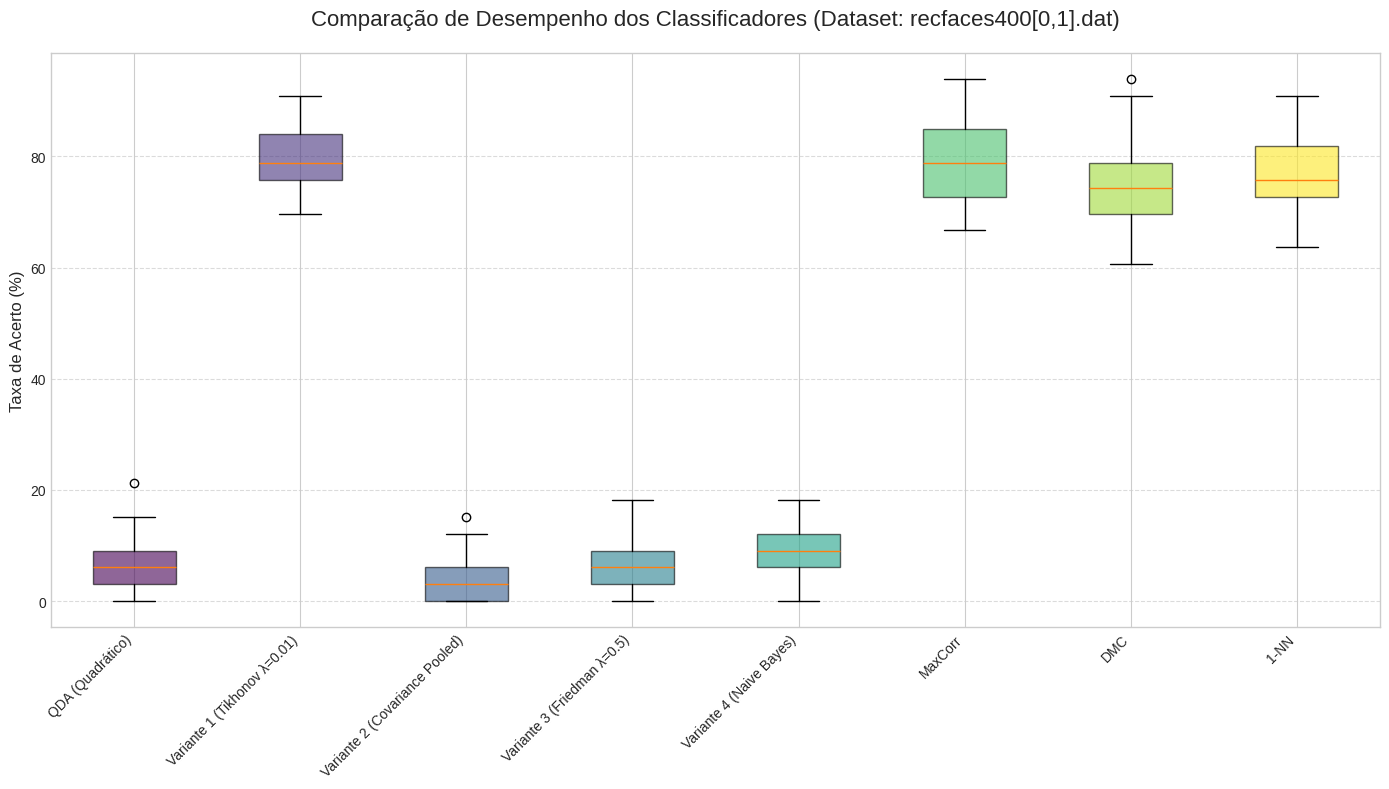

In [42]:
results = compara_todos('recfaces400[0,1].dat', Nr, Ptrain)

In [43]:
model_names = [
    "QDA (Quadrático)",
    "Variante 1 (Tikhonov λ=0.01)",
    "Variante 2 (Covariance Pooled)",
    "Variante 3 (Friedman λ=0.5)",
    "Variante 4 (Naive Bayes)"
]

for model in model_names:
    print(f"Postos das matrizes de covariância para {model}:")
    for i in results[1][model]["model_params"]["covariances_rank"]:
        print(results[1][model]["model_params"]["covariances_rank"][i])

Postos das matrizes de covariância para QDA (Quadrático):
10
7
8
7
9
9
6
8
4
7
8
6
8
8
7
Postos das matrizes de covariância para Variante 1 (Tikhonov λ=0.01):
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
Postos das matrizes de covariância para Variante 2 (Covariance Pooled):
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
Postos das matrizes de covariância para Variante 3 (Friedman λ=0.5):
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
Postos das matrizes de covariância para Variante 4 (Naive Bayes):
400
382
398
398
233
372
375
285
360
326
341
301
342
356
398


--- CARREGANDO DADOS DE 'recfaces400zscore.dat' ---

--- INICIANDO AVALIAÇÃO DOS CLASSIFICADORES (50 repetições, 80% treino) ---
Avaliando: QDA (Quadrático)...
Classificador: QDA (Quadrático)
Executando QDA...
Finalizado: QDA. Acurácia Média: 7.82%
Avaliando: Variante 1 (Tikhonov λ=0.01)...
Classificador: Variante 1 (Tikhonov λ=0.01)
Executando QDA...
Finalizado: QDA. Acurácia Média: 78.00%
Avaliando: Variante 2 (Covariance Pooled)...
Classificador: Variante 2 (Covariance Pooled)
Executando QDA...
Finalizado: QDA. Acurácia Média: 3.82%
Avaliando: Variante 3 (Friedman λ=0.5)...
Classificador: Variante 3 (Friedman λ=0.5)
Executando QDA...
Finalizado: QDA. Acurácia Média: 7.76%
Avaliando: Variante 4 (Naive Bayes)...
Classificador: Variante 4 (Naive Bayes)
Executando QDA...
Finalizado: QDA. Acurácia Média: 7.33%
Avaliando: MaxCorr...
Classificador: MaxCorr
Executando MaxCorr...
Finalizado: MaxCorr. Acurácia Média: 77.39%
Avaliando: DMC...
Classificador: DMC
Executando DMC...
Finalizado: DM

,Média (%),Mínimo (%),Máximo (%),Mediana (%),Desvio Padrão,Tempo (s)
QDA (Quadrático),7.82,0.00,18.18,6.06,4.50,32.35
Variante 1 (Tikhonov λ=0.01),78.00,66.67,90.91,78.79,5.99,8.09
Variante 2 (Covariance Pooled),3.82,0.00,24.24,3.03,5.24,41.37
Variante 3 (Friedman λ=0.5),7.76,0.00,18.18,9.09,4.16,41.70
Variante 4 (Naive Bayes),7.33,0.00,21.21,6.06,3.79,27.72
MaxCorr,77.39,60.61,90.91,75.76,6.48,0.03
DMC,77.15,63.64,90.91,75.76,6.78,0.05
1-NN,78.18,54.55,93.94,78.79,8.09,0.13


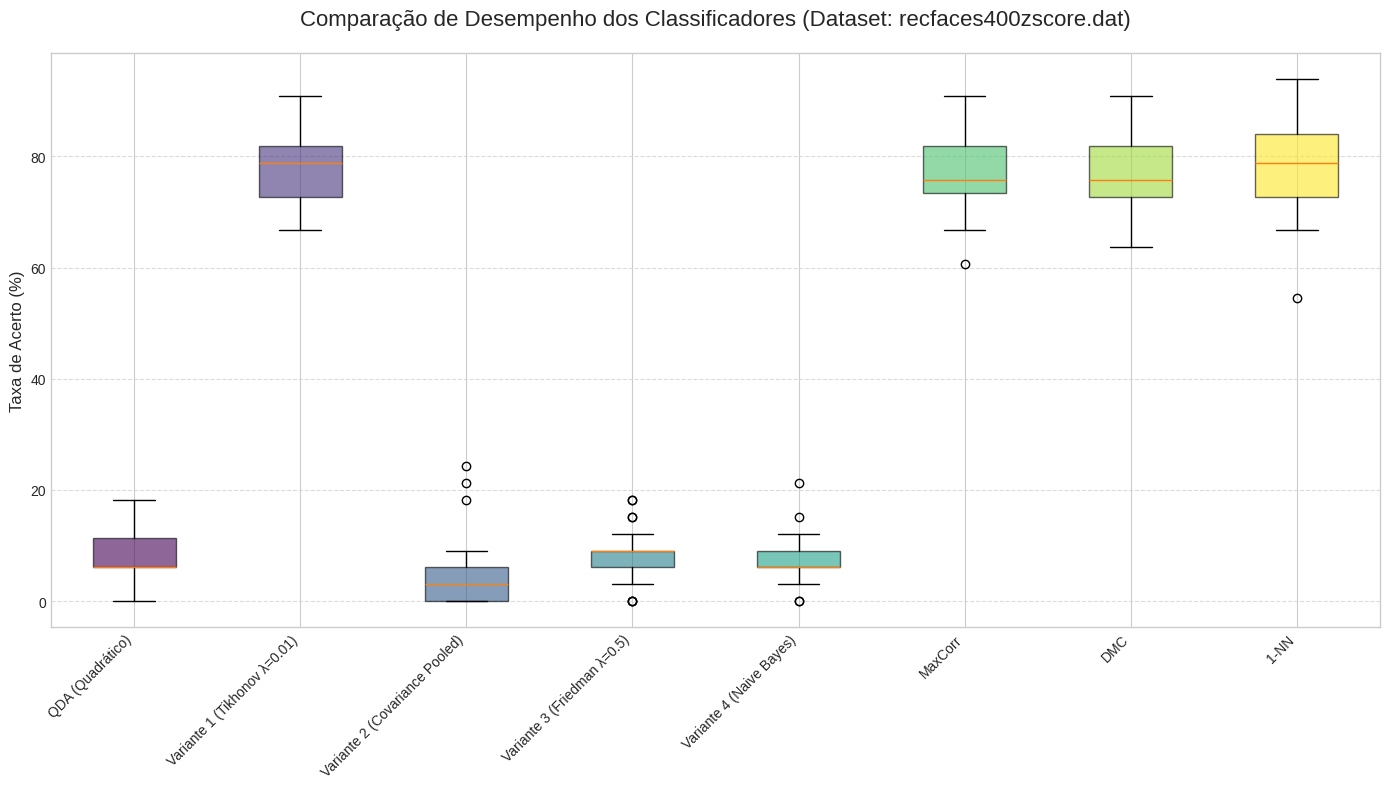

In [44]:
results = compara_todos('recfaces400zscore.dat', Nr, Ptrain)

In [45]:
model_names = [
    "QDA (Quadrático)",
    "Variante 1 (Tikhonov λ=0.01)",
    "Variante 2 (Covariance Pooled)",
    "Variante 3 (Friedman λ=0.5)",
    "Variante 4 (Naive Bayes)"
]

for model in model_names:
    print(f"Postos das matrizes de covariância para {model}:")
    for i in results[1][model]["model_params"]["covariances_rank"]:
        print(results[1][model]["model_params"]["covariances_rank"][i])

Postos das matrizes de covariância para QDA (Quadrático):
8
8
7
7
4
8
8
6
7
9
9
8
6
8
7
Postos das matrizes de covariância para Variante 1 (Tikhonov λ=0.01):
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
Postos das matrizes de covariância para Variante 2 (Covariance Pooled):
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
Postos das matrizes de covariância para Variante 3 (Friedman λ=0.5):
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
Postos das matrizes de covariância para Variante 4 (Naive Bayes):
400
233
398
398
399
308
293
288
361
326
226
329
342
356
398
